In [13]:
pip install ee

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
pip install geemap

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import ee
import geemap  
ee.Authenticate()
ee.Initialize(project='ee-kmd232323')

In [62]:
import ee
ee.Initialize()

# Load your Maharashtra district shapefile
maha = ee.FeatureCollection("users/kmd232323/Maha_districts")

# Define years and months of interest
years = [2021, 2022]
months = range(5, 12)  # May to November

# Define band calculation functions
def addNDVI(image):
    ndvi = image.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename('NDVI')
    return image.addBands(ndvi)

def addNDWI(image):
    ndwi = image.normalizedDifference(['sur_refl_b04', 'sur_refl_b02']).rename('NDWI')
    return image.addBands(ndwi)

def scaleLST(image):
    lst_celsius = image.select('LST_Day_1km').multiply(0.02).subtract(273.15).rename('LST')
    return image.addBands(lst_celsius)

# Get MODIS NDVI/NDWI
def get_ndvi_ndwi(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    return ee.ImageCollection("MODIS/061/MOD09GA") \
        .filterDate(start, end) \
        .filterBounds(maha) \
        .map(addNDVI).map(addNDWI) \
        .median() \
        .set('system:time_start', start.millis()) \
        .clip(maha)

# Get MODIS LST
def get_lst(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    return ee.ImageCollection("MODIS/061/MOD11A1") \
        .filterDate(start, end) \
        .filterBounds(maha) \
        .map(scaleLST) \
        .median() \
        .set('system:time_start', start.millis()) \
        .clip(maha)

# Get CHIRPS Rainfall
def get_rainfall(year, month):
    start = ee.Date.fromYMD(year, month, 1)
    end = start.advance(1, 'month')
    return ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
        .filterDate(start, end) \
        .filterBounds(maha) \
        .sum() \
        .rename("Rainfall") \
        .set('system:time_start', start.millis()) \
        .clip(maha)

# MAI = AET / PET; here we simulate with NDVI * Rainfall / PET
def calculate_mai(image):
    PET = ee.Number(100)  # Simulated constant PET, replace if actual PET is available
    mai = image.expression(
        '(ndvi * rain) / PET', {
            'ndvi': image.select('NDVI'),
            'rain': image.select('Rainfall'),
            'PET': PET
        }
    ).rename('MAI')
    return image.addBands(mai)

# Merge all bands from the same month
def merge_features(year, month):
    ndvi_ndwi = get_ndvi_ndwi(year, month)
    lst = get_lst(year, month)
    rainfall = get_rainfall(year, month)

    merged = lst.addBands(ndvi_ndwi.select(['NDVI', 'NDWI'])) \
                .addBands(rainfall.select('Rainfall')) \
                .set('system:time_start', lst.get('system:time_start'))

    return calculate_mai(merged)

# Build image collection
merged_images = [merge_features(y, m) for y in years for m in months]
merged_collection = ee.ImageCollection(merged_images)

# Extract mean per district for each image
def extract_district_features(image):
    date = image.date().format("YYYY-MM-dd")
    stats = image.select(['NDVI', 'NDWI', 'LST', 'Rainfall', 'MAI']) \
        .reduceRegions(
            collection=maha,
            reducer=ee.Reducer.mean(),
            scale=1000
        ).map(lambda f: f.set('date', date))
    return stats

district_stats = merged_collection.map(extract_district_features).flatten()

# Export to Drive as CSV
task = ee.batch.Export.table.toDrive(
    collection=district_stats,
    description='Maha_Drought_Features',
    fileFormat='CSV'
)
task.start()

print("✅ Export started! Monitor it in the Earth Engine Tasks tab.")


✅ Export started! Monitor it in the Earth Engine Tasks tab.


In [65]:
from IPython.display import display, HTML, Image
import ee

# Visualization parameters
vis_params = {
    'bands': ['NDVI'],
    'min':  -0.1482,
    'max': 0.778,
    'palette': ['blue', 'white', 'green']
}

# Get the region geometry
region = maha.geometry().getInfo()

# Outline for boundary
maha_outline = maha.geometry()
maha_boundary_image = ee.Image().paint(maha_outline, 1, 2)

# Convert FeatureCollection to list
num_images = merged_collection.size().getInfo()
merged_list = merged_collection.toList(num_images)

# Collect images and dates
thumbnails = []

for i in range(num_images):
    img = ee.Image(merged_list.get(i))
    date_str = ee.Date(img.get('system:time_start')).format('YYYY-MM').getInfo()

    # Create blended image
    img_with_boundary = img.visualize(**vis_params).blend(
        maha_boundary_image.visualize(palette='white')
    )

    # Thumbnail parameters
    thumb_params = {
        'dimensions': 512,
        'region': region,
        'format': 'png'
    }

    # Generate thumbnail URL and save with date
    thumb_url = img_with_boundary.getThumbURL(thumb_params)
    thumbnails.append((date_str, thumb_url))

# Sort thumbnails by date
thumbnails.sort()

# Split into two rows (2021 and 2022)
row1 = thumbnails[:7]  # First 7 images
row2 = thumbnails[7:14]  # Next 7 images

# Create HTML table for display
html = "<table style='border-collapse: collapse;'>"

for row in [row1, row2]:
    html += "<tr>"
    for date_str, url in row:
        html += f"<td style='padding:10px; text-align:center;'><img src='{url}' width='256'><br>{date_str}</td>"
    html += "</tr>"

html += "</table>"

# Display the grid
display(HTML(html))


2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11
2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11


In [72]:
pip install scikit-learn

     ---------------------------------------- 11.1/11.1 MB 4.4 MB/s eta 0:00:00
     ---------------------------------------- 41.2/41.2 MB 3.8 MB/s eta 0:00:00
     -------------------------------------- 301.8/301.8 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [80]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


# Load your exported CSV
df = pd.read_csv('C:/Ketaki Dharmadhikari/Engineering/4th Year/Remote Sensing OEA/Maha_Drought_Features.csv')

scaler = MinMaxScaler()
df['Rainfall_norm'] = scaler.fit_transform(df[['Rainfall']])

scaler = MinMaxScaler()
df['LST_norm'] = scaler.fit_transform(df[['LST']])

# List of columns to DROP
drop_cols = [
    'system:index', 'CC_2', 'COUNTRY', 'ENGTYPE_2', 'GID_0', 'GID_1', 'GID_2',
    'HASC_2', 'NAME_1', 'NL_NAME_1', 'NL_NAME_2', 'TYPE_2', 'VARNAME_2','Rainfall','LST'
]

# Drop unwanted columns
df_cleaned = df.drop(columns=drop_cols, errors='ignore')

# Save for visualization (keep .geo column)
df_cleaned.to_csv('district_drought_viz.csv', index=False)

# Save for ML modeling (remove .geo column)
df_model = df_cleaned.drop(columns=['.geo'], errors='ignore')
df_model.to_csv('district_drought_model.csv', index=False)





In [81]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


First 5 rows of the dataset:
        MAI      NAME_2      NDVI      NDWI        date  Rainfall_norm  \
0  0.172139  Ahmadnagar  0.287072 -0.358323  2021-05-01       0.043976   
1  0.051848    Amravati  0.247005 -0.340334  2021-05-01       0.014687   
2  0.161490         Bid  0.261540 -0.343257  2021-05-01       0.045377   
3  0.080371  Chandrapur  0.304323 -0.384044  2021-05-01       0.018257   
4  0.056946       Dhule  0.227534 -0.340216  2021-05-01       0.017907   

   LST_norm  
0  0.808900  
1  0.909835  
2  0.861806  
3  0.806897  
4  0.939034  

Summary Statistics of the dataset:
              MAI        NDVI        NDWI  Rainfall_norm    LST_norm
count  504.000000  504.000000  504.000000     504.000000  504.000000
mean     0.271816    0.253118   -0.251132       0.149062    0.381290
std      0.255935    0.212256    0.209738       0.156818    0.232371
min      0.000000    0.004980   -0.689401       0.000000    0.000000
25%      0.089117    0.088956   -0.428230       0.036403    0

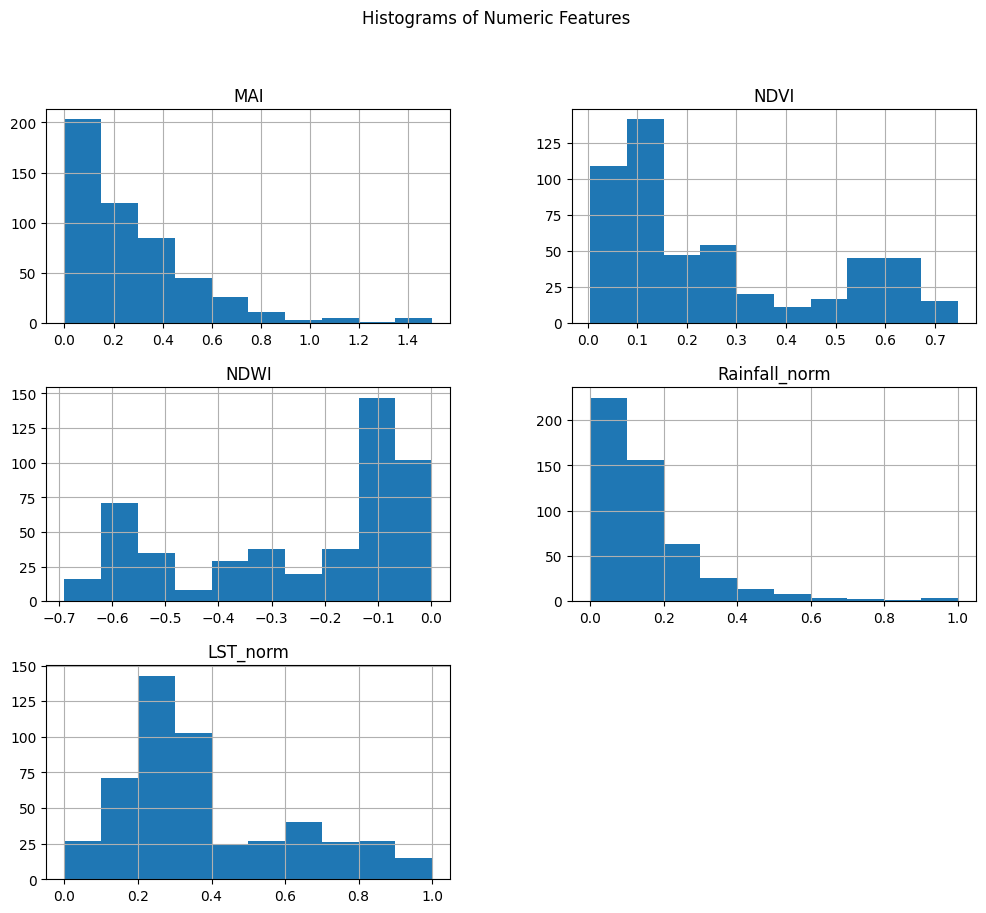

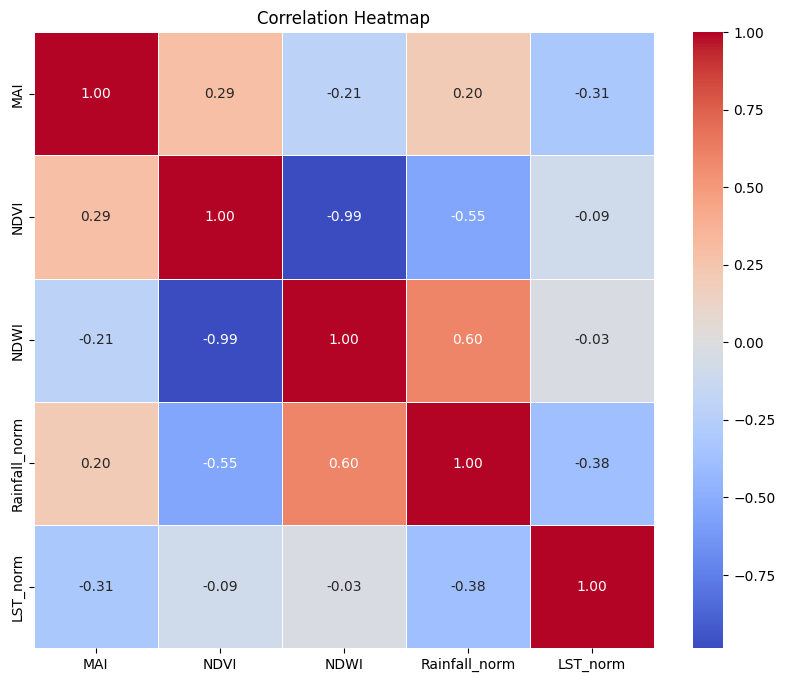

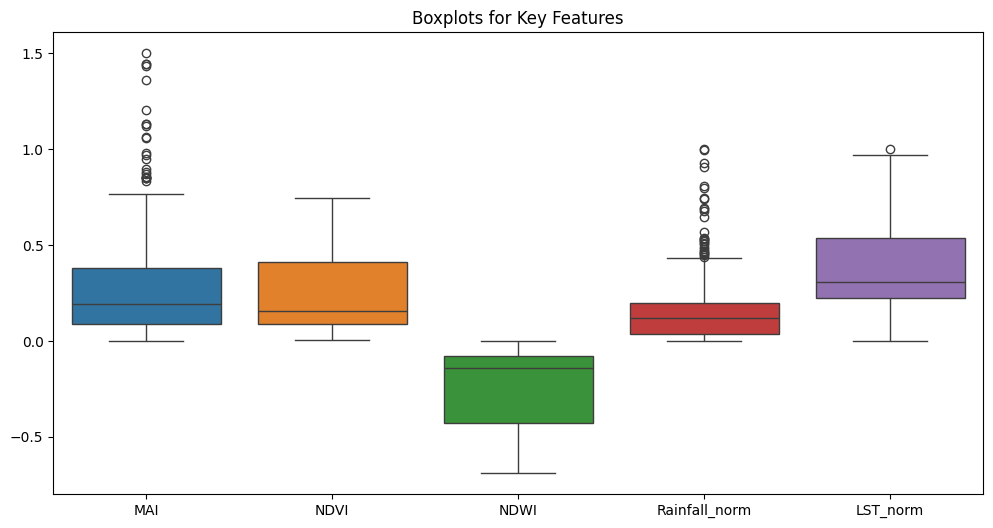

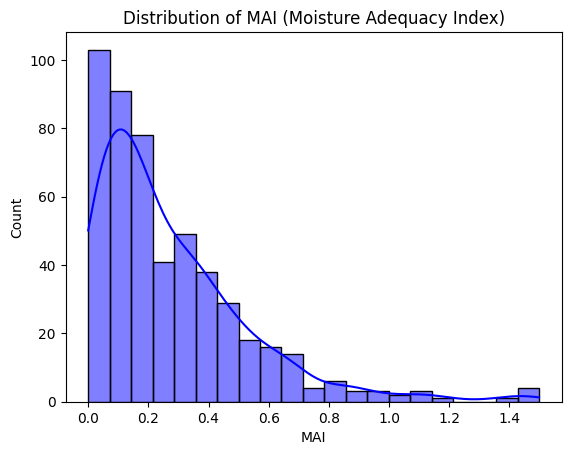

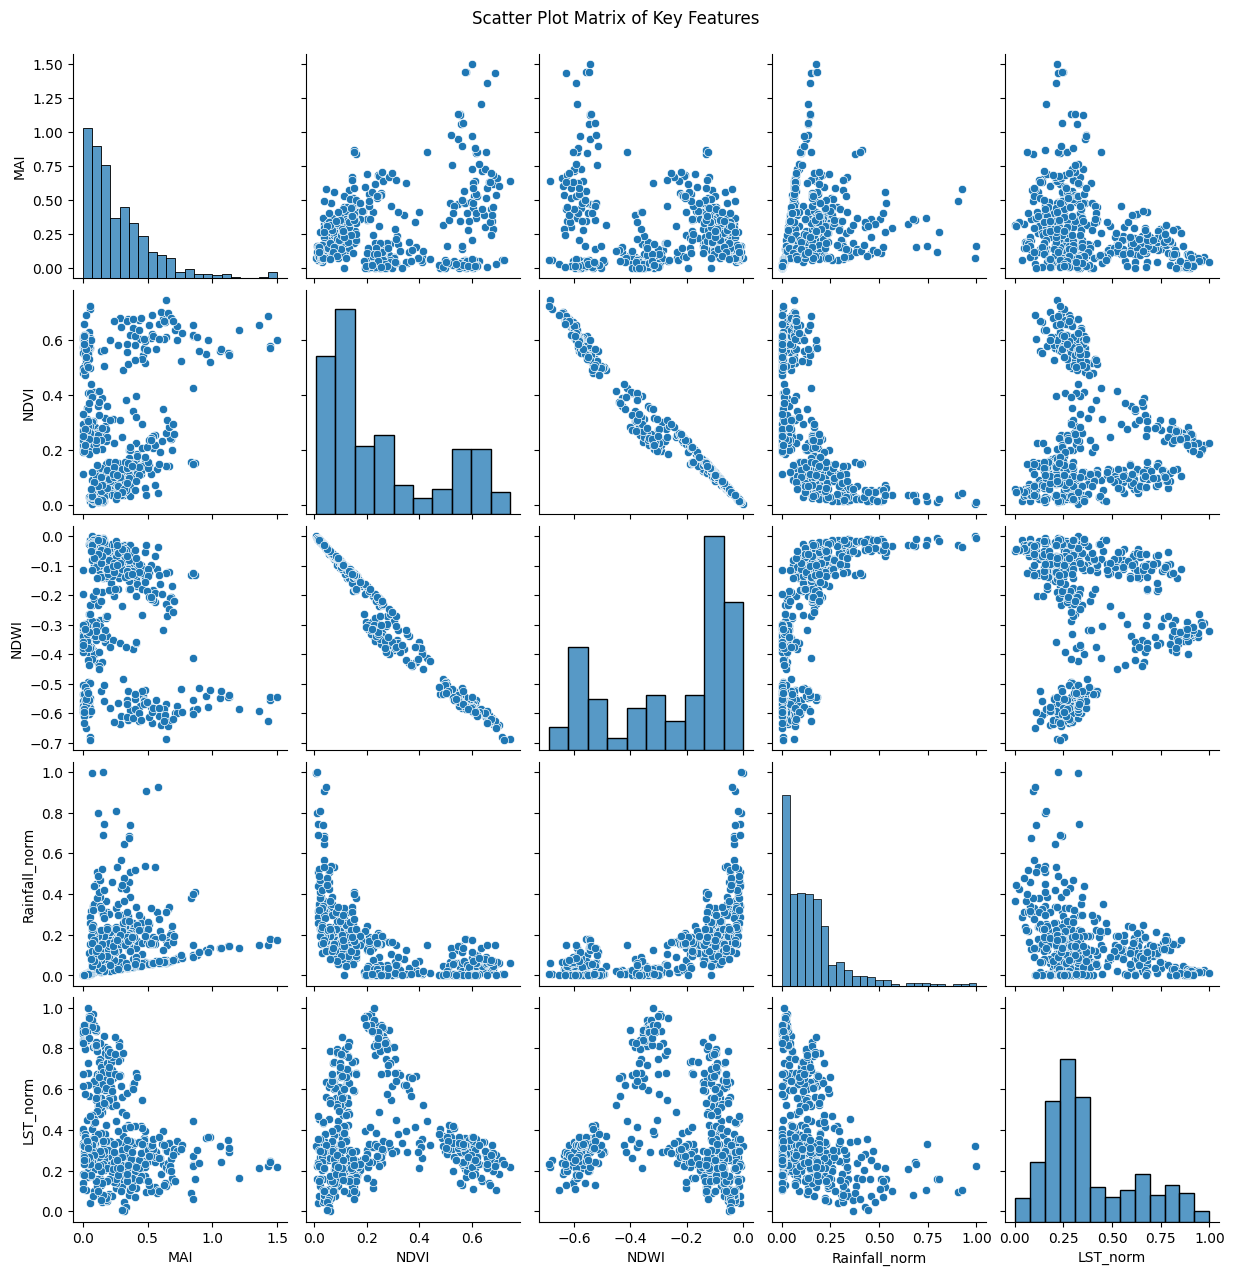

In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('district_drought_model.csv')

print("First 5 rows of the dataset:")
print(df.head())

print("\nSummary Statistics of the dataset:")
print(df.describe())

print("\nMissing values in each column:")
print(df.isnull().sum())

df[['MAI', 'NDVI', 'NDWI', 'Rainfall_norm', 'LST_norm']].hist(figsize=(12, 10))
plt.suptitle('Histograms of Numeric Features')
plt.show()

plt.figure(figsize=(10, 8))
correlation_matrix = df[['MAI', 'NDVI', 'NDWI', 'Rainfall_norm', 'LST_norm']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['MAI', 'NDVI', 'NDWI', 'Rainfall_norm', 'LST_norm']])
plt.title('Boxplots for Key Features')
plt.show()

sns.histplot(df['MAI'], kde=True, color='blue')
plt.title('Distribution of MAI (Moisture Adequacy Index)')
plt.show()

sns.pairplot(df[['MAI', 'NDVI', 'NDWI', 'Rainfall_norm', 'LST_norm']])
plt.suptitle('Scatter Plot Matrix of Key Features', y=1.02)
plt.show()



In [85]:
# Define drought categories based on MAI values
def classify_drought(mai):
    if mai >= 0.75:
        return 'No Drought'
    elif mai >= 0.5:
        return 'Moderate'
    else:
        return 'Severe'

# Apply classification to create target labels
df['Drought_Class'] = df['MAI'].apply(classify_drought)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode drought class labels into numerical values
le = LabelEncoder()
df['Drought_Label'] = le.fit_transform(df['Drought_Class'])

# Features and target
X = df[['NDVI', 'NDWI', 'LST_norm', 'Rainfall_norm']]
y = df['Drought_Label']

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

    Moderate       0.88      0.88      0.88         8
  No Drought       1.00      0.83      0.91         6
      Severe       0.99      1.00      0.99        87

    accuracy                           0.98       101
   macro avg       0.95      0.90      0.93       101
weighted avg       0.98      0.98      0.98       101

Confusion Matrix:
 [[ 7  0  1]
 [ 1  5  0]
 [ 0  0 87]]
